# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


## Подготовка

In [13]:
#warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import warnings

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet') 
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [15]:
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['text', 'toxic'], dtype='object')

Удалим ненужный столбец

In [16]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Проверим датасет на предмет пропусков

<AxesSubplot:ylabel='toxic'>

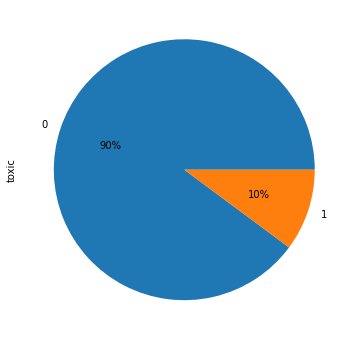

In [17]:

df['toxic'].value_counts().plot(kind='pie', figsize=(10, 6), autopct='%1.0f%%')

Можно заметить, что в задаче присутствует проблема дисбаланса классов

In [21]:
def get_pos(tag): 
    if tag.startswith('J'): 
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'): 
        return wordnet.NOUN
    elif tag.startswith('R'): 
        return wordnet.ADV
    else: 
        return wordnet.NOUN

def lemmatize(text): 
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text) 
    tagged_tokens = nltk.pos_tag(tokens) 
    lemmas = [lemmatizer.lemmatize(token, get_pos(tag)) for token, tag in tagged_tokens]
    return ' '.join(lemmas)

In [22]:
def clear(text):
    return ' '.join(re.sub(r'[^a-zA-Z ]',' ', text).split())

Выведем нужные для дальнейшего анализа функции

Очистим и лемматизируем текст

In [23]:
corpus = []
for i in df['text']: 
    corpus.append(lemmatize(clear(i)))

In [24]:
print(df['text'][0])
print(corpus[0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Explanation Why the edits make under my username Hardcore Metallica Fan be revert They weren t vandalism just closure on some GAs after I vote at New York Dolls FAC And please don t remove the template from the talk page since I m retire now


## Обучение

In [25]:
X = corpus
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, random_state=12345, test_size=0.2)

Для обучения моделей выведем X и у

In [26]:
stopwords = set(stopwords.words('english')) 
tfidf = TfidfVectorizer(stop_words=stopwords) 

X_train = tfidf.fit_transform(X_train) 
X_test = tfidf.transform(X_test) 

Подсчитаем TF-IDF

In [27]:
model = LogisticRegression(class_weight='balanced', random_state=12345) 

param_grid = {
    'max_iter': [10, 100],
    'C': [0.1, 1, 10]
}

search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

Найдем оптимальные гиперпараметры для логистической регрессии

In [28]:
%%time
search.fit(X_train, y_train) 

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

CPU times: user 3min 28s, sys: 7min 10s, total: 10min 39s
Wall time: 10min 40s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [10, 100]},
             scoring='f1')

In [29]:
print('Лучшее значение метрики:', search.best_score_)

Лучшее значение метрики: 0.7598502134674535


Значение метрики получилось равно 0,76

In [30]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=12345) 

param_rfc = {
    'max_depth': [2, 6, 10],
    'n_estimators': [10, 20, 30]
}

search_rfc = GridSearchCV(rfc, param_rfc, cv=5, scoring='f1')

Попробуем вторую модель 

In [55]:
%%time
search_rfc.fit(X_train, y_train)

CPU times: user 1min 50s, sys: 1.31 s, total: 1min 51s
Wall time: 1min 51s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'max_depth': [2, 6, 10], 'n_estimators': [10, 20, 30]},
             scoring='f1')

In [56]:
print('Лучшее значение метрики:', search_rfc.best_score_) 

0.3237258652061078


Значение метрики получилось 0.32, что говорит о том, что модель не может быть использована далее

## Выводы

In [31]:
model = search.best_estimator_ 

model.fit(X_train, y_train) 

pred = model.predict(X_test) 

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Обучим лучшую модель на тестовой выборке

In [32]:
print('F1 на тестовой выборке равно:', f1_score(y_test, pred))

F1 на тестовой выборке равно: 0.7636259323006312


Метрика F1 получилась равна 0.76, что выше требуемого порога. Таким образом можно заключить, что лучше всего себя показала модель логистической регрессии. Всего в ходе анализа были найдены оптимальные гиперпараметры для двух моделей: Logistic Regression и Random Forest Classifier. В ходе предобработки данных был удален ненужный столбец, который не мог положительно повлиять на точность обучения моделей. Также была найдена проблема дисбаланса классов, которая была решена через установление параметра class_weight = 'balanced'. Таким образом на тестовой выборке лучше всего использовать модель логистической регрессии, потому что для нее F1 мера составляет 0.76. 